# Data Processing

In [1]:
import os
import pandas as pd
import numpy as np
import scipy.stats as st

Extract

- Go through all the logs and extract the raw data
- skip empty logs that did not collect data

In [37]:
def extractLogs(dirpath: str, filename: str) -> pd.DataFrame:
    # Parse the dataframe from json
    df = pd.read_json(f"{dirpath}/{filename}", orient="index")
    df = df.reset_index(names="operation")

    # Re-orient the nested columns to tabularized data
    df = pd.concat(
        df.apply(
            lambda row: pd.DataFrame(
                [
                    # tabularize the baseline results
                    {
                        "operation": (
                            row.operation
                            if row.operation in ["create", "delete"]
                            else "execute"
                        ),
                        "sample": 0,
                        **row.baseline,
                        "response_time": row.response_time,
                    },
                    # tabularize the samples
                    *[
                        {
                            "operation": (
                                row.operation
                                if row.operation in ["create", "delete"]
                                else "execute"
                            ),
                            **{k: v for k, v in sample.items()},
                            "response_time": row.response_time,
                        }
                        for sample in row.samples
                    ],
                ]
            ),
            axis=1
        ).tolist(),
        ignore_index=True
    )

    # -- Get test information
    # from filename
    file_split = filename.split("_")
    fnc = file_split[0]
    iteration = int(file_split[2])
    db_size = int(file_split[4].split(".")[0])

    # from directory path
    dir_split = dirpath.split("/")[-1].split("\\")
    test_no = int(dir_split[0][0])
    test_type = dir_split[2]
    machine = dir_split[0][1:]

    # Set the entire column based on parsed data
    df["machine"] = machine
    df["db_type"] = test_type
    df["db_size"] = db_size
    df["test_no"] = test_no
    df["iteration"] = iteration
    
    # Eliminate sufix
    if (test_type == "structured"):
        df["function"] = fnc[:-6]
    else:
        df["function"] = fnc[:-8]

    # Set numeric columns
    df[[
        'db_size', 'test_no', 'iteration', 'sample', 'cpu_util',
        'disk_read', 'disk_write', 'disk_used', 'disk_free',
        'virtual_used', 'virtual_free', 'response_time'
    ]].astype(float)

    # Set the order of the table
    df = df[[
        "machine", "db_type", "function", "operation",
        "db_size", "test_no", "iteration", "sample", "cpu_util",
        "disk_read", "disk_write", "disk_used", "disk_free",
        "virtual_used", "virtual_free","response_time"
    ]]

    return df

def runExtract() -> pd.DataFrame:
    # go through all the files and save records
    results = []
    for dirpath, _, filenames in os.walk("../logs/"):
        for filename in filenames:
            if (filename.endswith(".json")):
                try:
                    # save files
                    r = extractLogs(dirpath, filename)
                    results.append(r)
                # ignore empty files
                except ValueError as e:
                    continue

    # combine and print
    return pd.concat(results)

e_df = runExtract()
e_df

,machine,db_type,function,operation,db_size,test_no,iteration,sample,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time
0,medium,structured,aggregate,delete,10,0,0,0,52.4,1.443598,28.730371,5.063541,22.938534,3.021351,0.725601,0.001020
1,medium,structured,aggregate,delete,10,0,0,1,50.0,1.443598,28.730375,5.063545,22.938530,3.021343,0.725609,0.001020
2,medium,structured,aggregate,create,10,0,0,0,60.0,1.443598,28.730459,5.063854,22.938221,3.021057,0.725895,0.028347
3,medium,structured,aggregate,create,10,0,0,1,85.0,1.443606,28.730967,5.064682,22.937393,3.020138,0.726814,0.028347
4,medium,structured,aggregate,execute,10,0,0,0,57.1,1.443606,28.748194,5.064682,22.937393,3.020008,0.726944,0.001489
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
45,smalls,unstructured,insertOne,create,1000000,4,2,43,65.0,1.893312,4.040453,4.035873,23.966202,1.833820,0.032047,21.681869
46,smalls,unstructured,insertOne,create,1000000,4,2,44,75.0,1.893312,4.049124,4.039600,23.962475,1.835991,0.029877,21.681869
47,smalls,unstructured,insertOne,create,1000000,4,2,45,9.5,1.893781,4.050531,4.040947,23.961128,1.796898,0.068970,21.681869
48,smalls,unstructured,insertOne,execute,1000000,4,2,0,5.0,1.893956,4.050531,4.040947,23.961128,1.796806,0.069061,0.006187


Transform
- each operation samples the resources, aggregate the samples and store them as one value
- use average for cpu usage and response time
- use max and min for memory usage (disk and RAM)

In [38]:
def transformFrame(df: pd.DataFrame) -> pd.DataFrame:
    # groups by the sample in each iteration
    df = (
        df
        .groupby(["machine", "db_type","function","operation","db_size","test_no","iteration"])
        .agg({
            "cpu_util": "median",
            "disk_read": "max",
            "disk_write": "max",
            "disk_used": "max",
            "disk_free": "min",
            "virtual_used": "max",
            "virtual_free": "min",
            "response_time": "mean"
            })
    )

    return df.reset_index()

t_df = transformFrame(e_df.copy(deep=True))
t_df

,machine,db_type,function,operation,db_size,test_no,iteration,cpu_util,disk_read,disk_write,disk_used,disk_free,virtual_used,virtual_free,response_time
0,medium,structured,aggregate,create,10,0,0,72.50,1.443606,28.730967,5.064682,22.937393,3.021057,0.725895,0.028347
1,medium,structured,aggregate,create,10,0,1,52.75,1.443606,28.750166,4.967445,23.034630,3.023819,0.723133,0.019826
2,medium,structured,aggregate,create,10,0,2,53.95,1.443606,28.751482,4.925236,23.076839,3.033745,0.713207,0.022511
3,medium,structured,aggregate,create,10,0,3,53.55,1.443606,28.751787,4.925247,23.076828,3.033710,0.713242,0.019926
4,medium,structured,aggregate,create,10,0,4,53.70,1.443606,28.752035,4.925262,23.076813,3.033680,0.713272,0.019918
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
14701,smalls,unstructured,updateOne,execute,100000,4,0,20.00,0.325700,1.493464,4.375790,23.626286,1.142704,0.723164,0.082442
14702,smalls,unstructured,updateOne,execute,100000,4,1,23.70,0.325704,1.503073,4.385948,23.616127,1.137939,0.727928,0.103406
14703,smalls,unstructured,updateOne,execute,100000,4,2,22.50,0.325738,1.572260,3.821026,24.181049,1.056908,0.808960,0.078894
14704,smalls,unstructured,updateOne,execute,100000,4,3,19.05,0.325738,1.581869,3.833317,24.168758,1.062370,0.803497,0.076084


Confidence Interval
- uses block mean
    - each iteration is run consequtively so there is some dependancy
    - each test is run after all other tests have been run so they are independant
    - block mean: calculate the mean for the dependentant results then the mean of the independant
    - reduces the sample size so the confidence interval has a larger range
- function is used to extract the confidence interval for a single metric at a time

In [39]:
def block_confidence(
        df: pd.DataFrame,
        value_col: str,
        alpha: float=0.05,
        execute_only: bool=True
    ) -> pd.DataFrame:

    if execute_only:
        df = df[df["operation"] == "execute"]
        group = ['machine','db_type','function','db_size']
    else:
        df = df[df["operation"] != "execute"]
        group = ['machine','db_type','operation','db_size']


    # iteration mean
    iter_df = (
        df
        .groupby(['machine','db_type','function','operation','db_size','test_no'])[value_col]
        .mean()
        .reset_index(name='iter_mean')
    )
    
    # mean within between tests
    test_df = (
        iter_df
        .groupby(group)['iter_mean']
        .agg(['mean','std','count'])
        .reset_index()
    )

    # standard error
    test_df['se'] = test_df['std'] / np.sqrt(test_df['count'])

    # get t value for sample
    test_df['t'] = test_df['count'].apply(lambda n: st.t.ppf(1 - alpha/2, df=n-1))

    # error
    test_df['error'] = test_df['se'] * test_df['t']

    # CI - lower and upper bounds
    test_df['ci_lower'] = test_df['mean'] - test_df['error']
    test_df['ci_upper'] = test_df['mean'] + test_df['error']

    # filter columns
    test_df = test_df[group + ['mean','ci_lower','ci_upper']]

    return test_df

# Analysis

In [13]:
import matplotlib.pyplot as plt

Overview

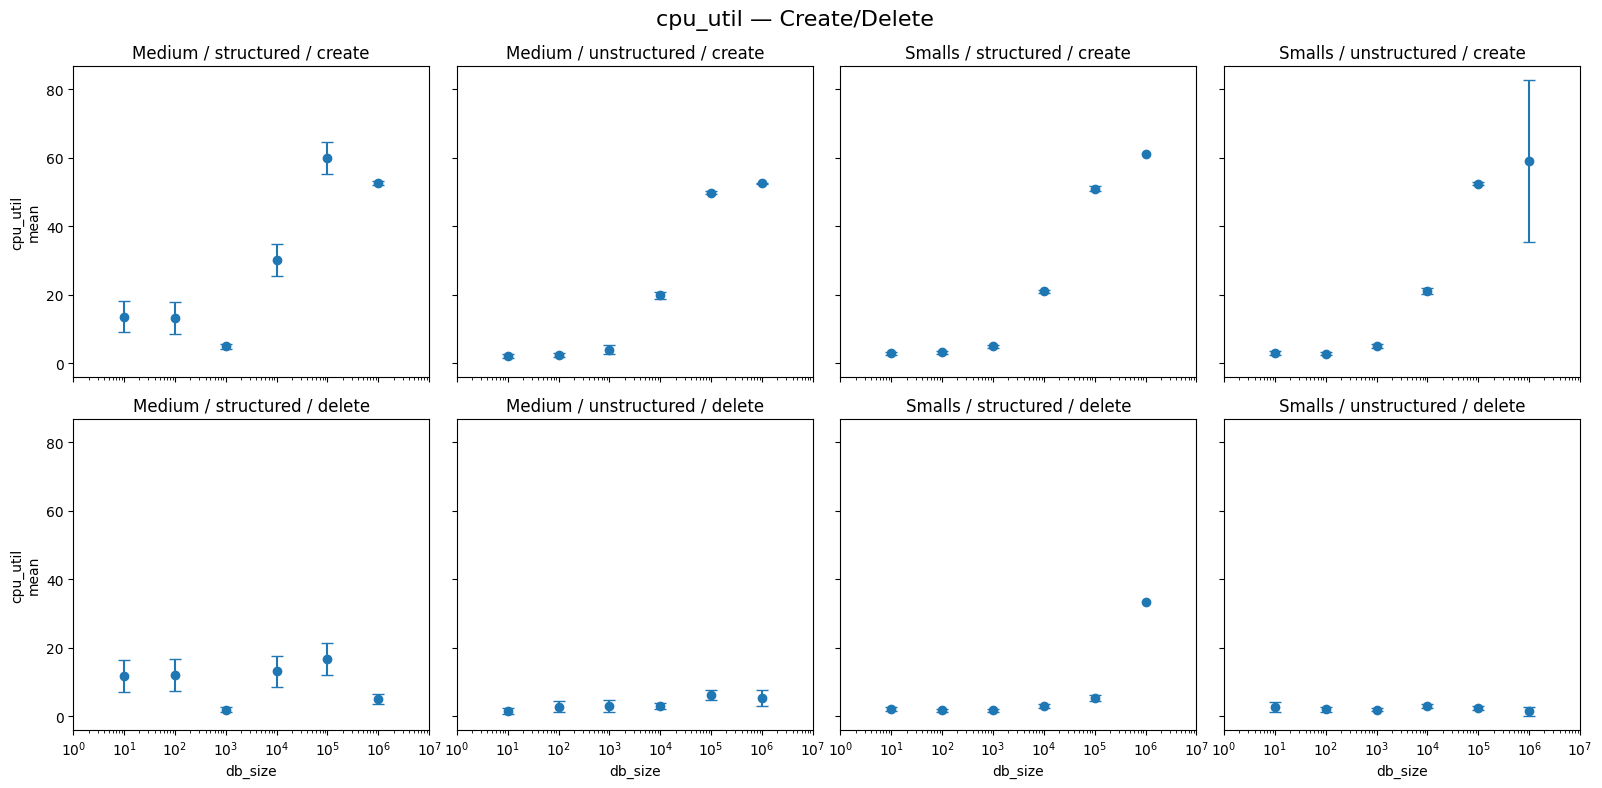

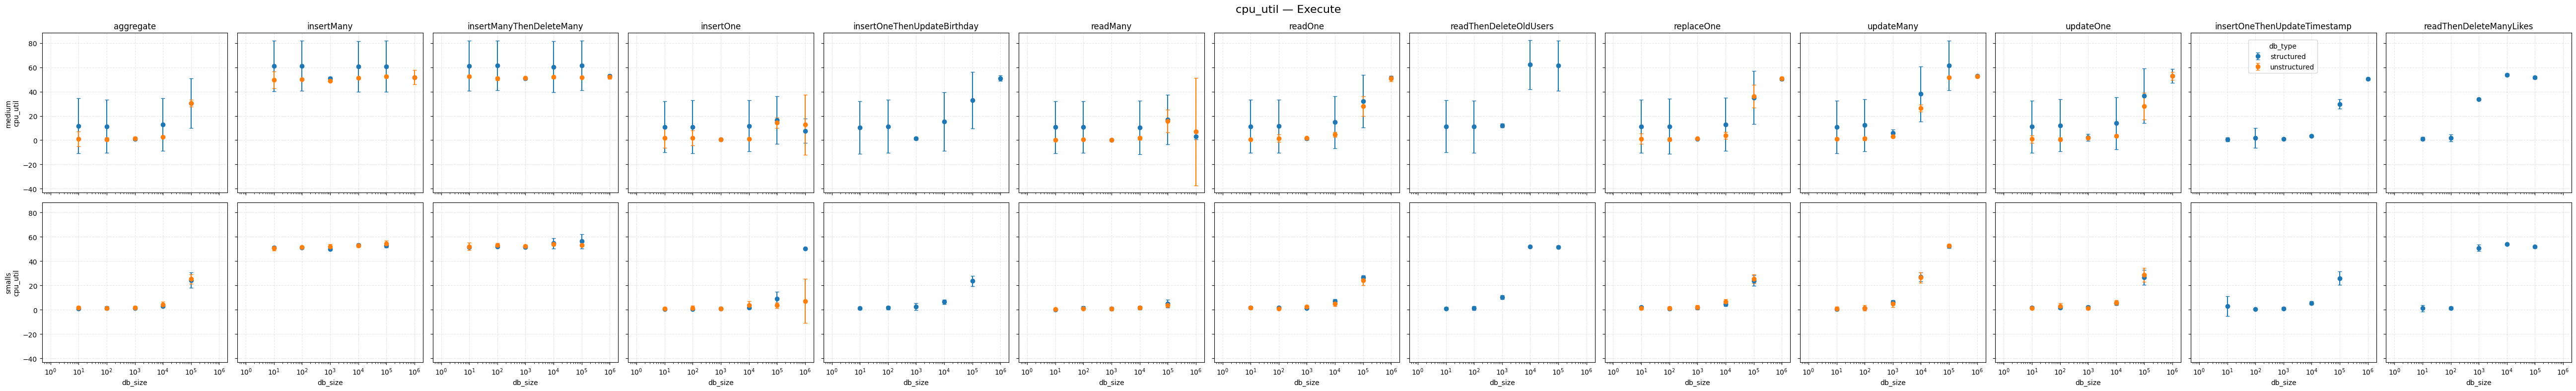

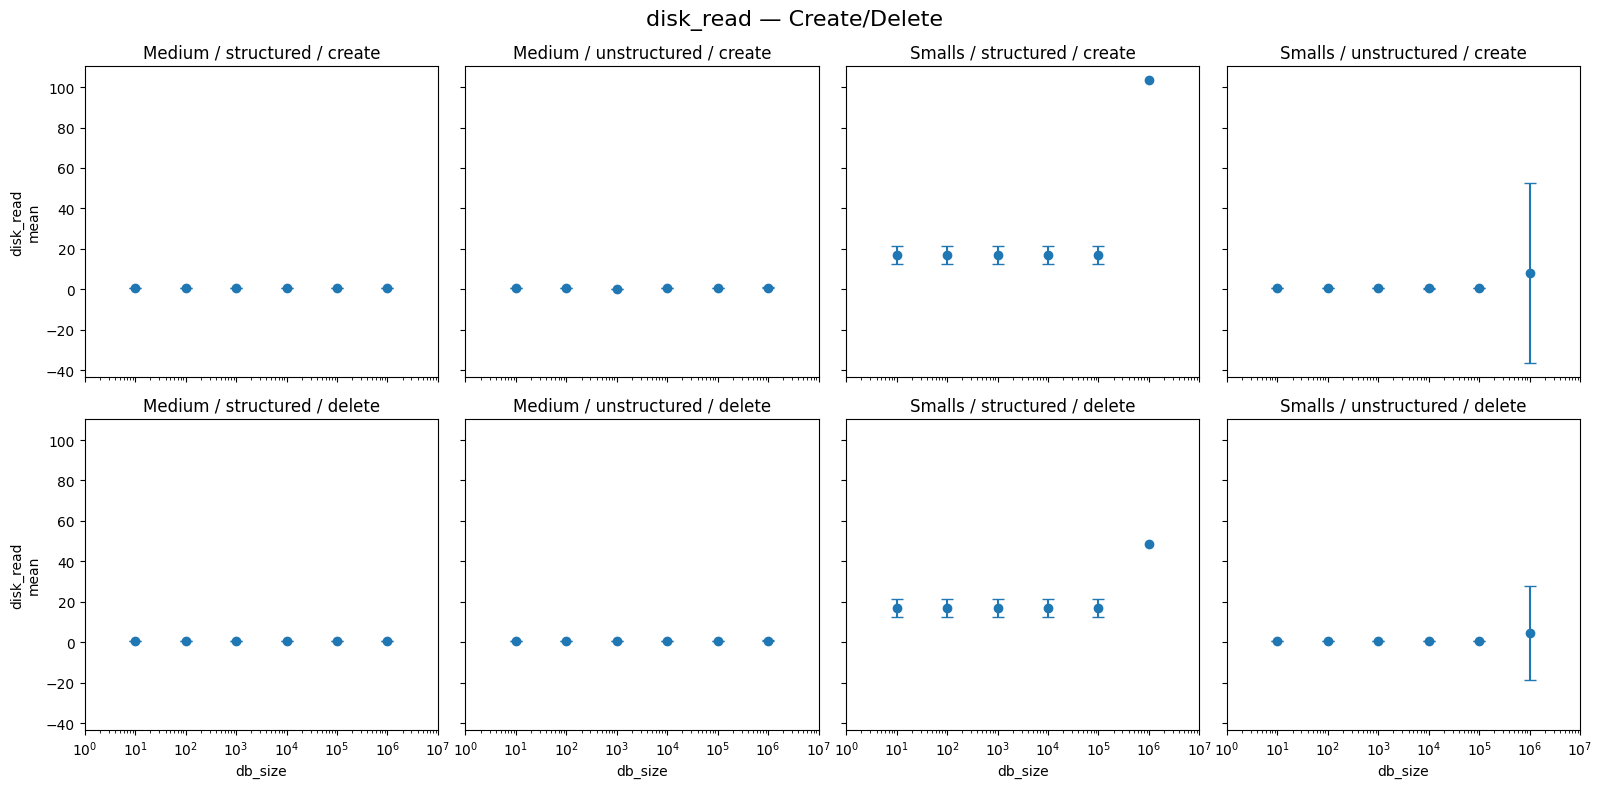

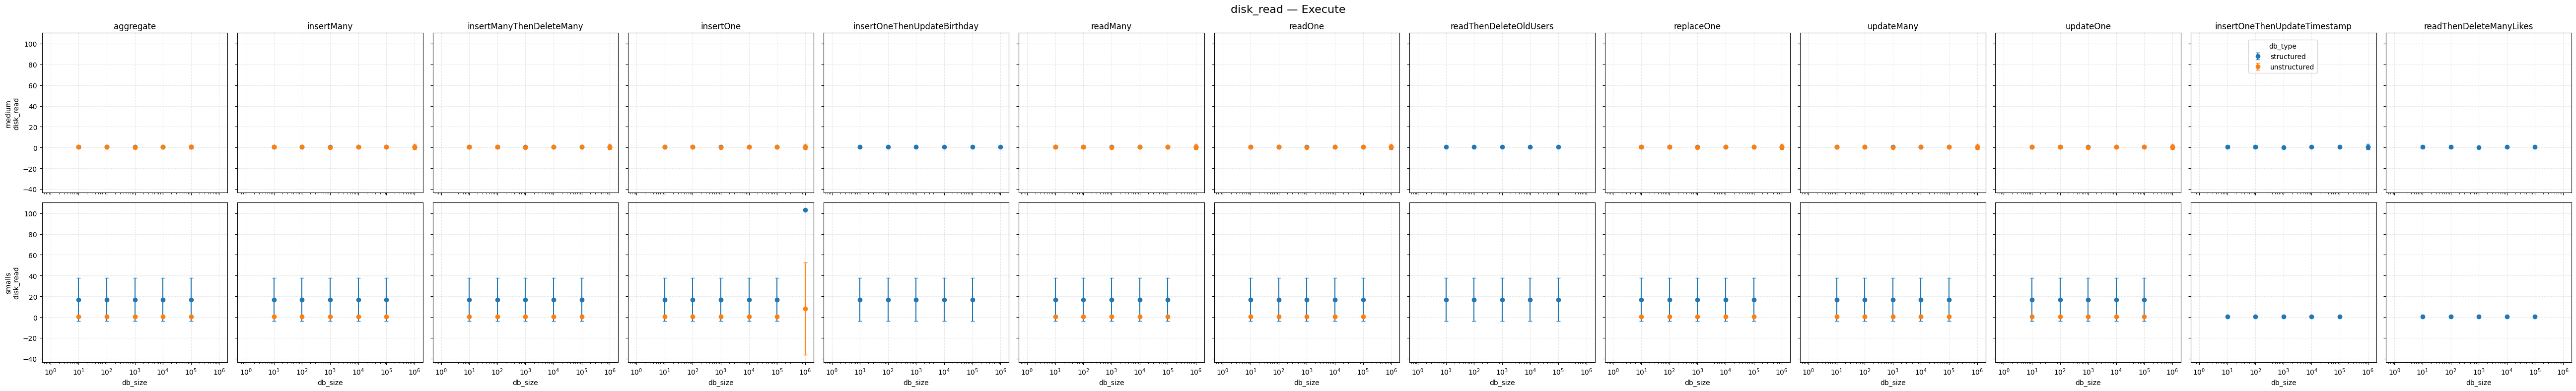

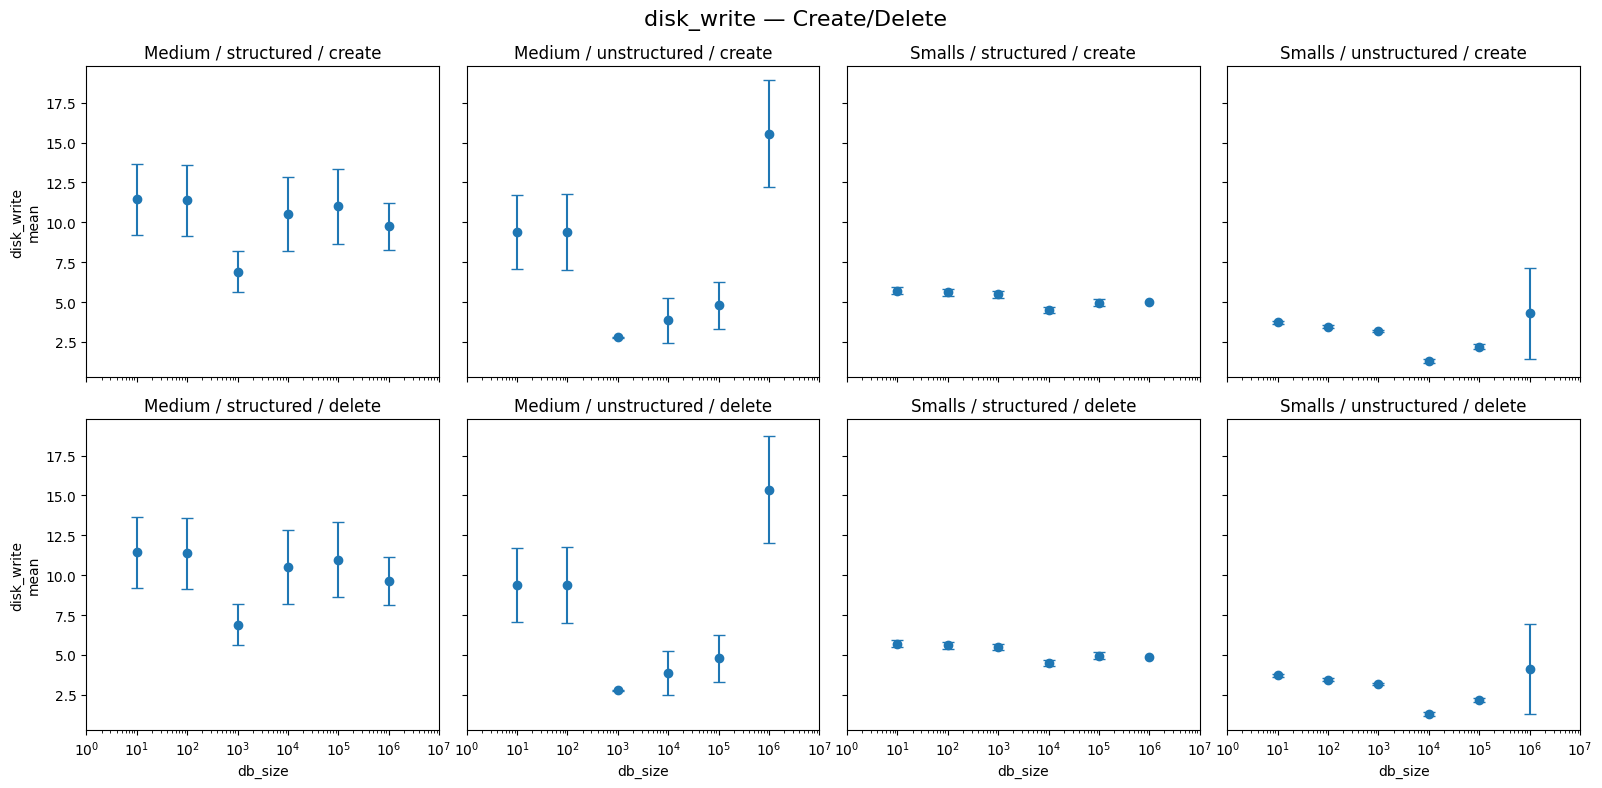

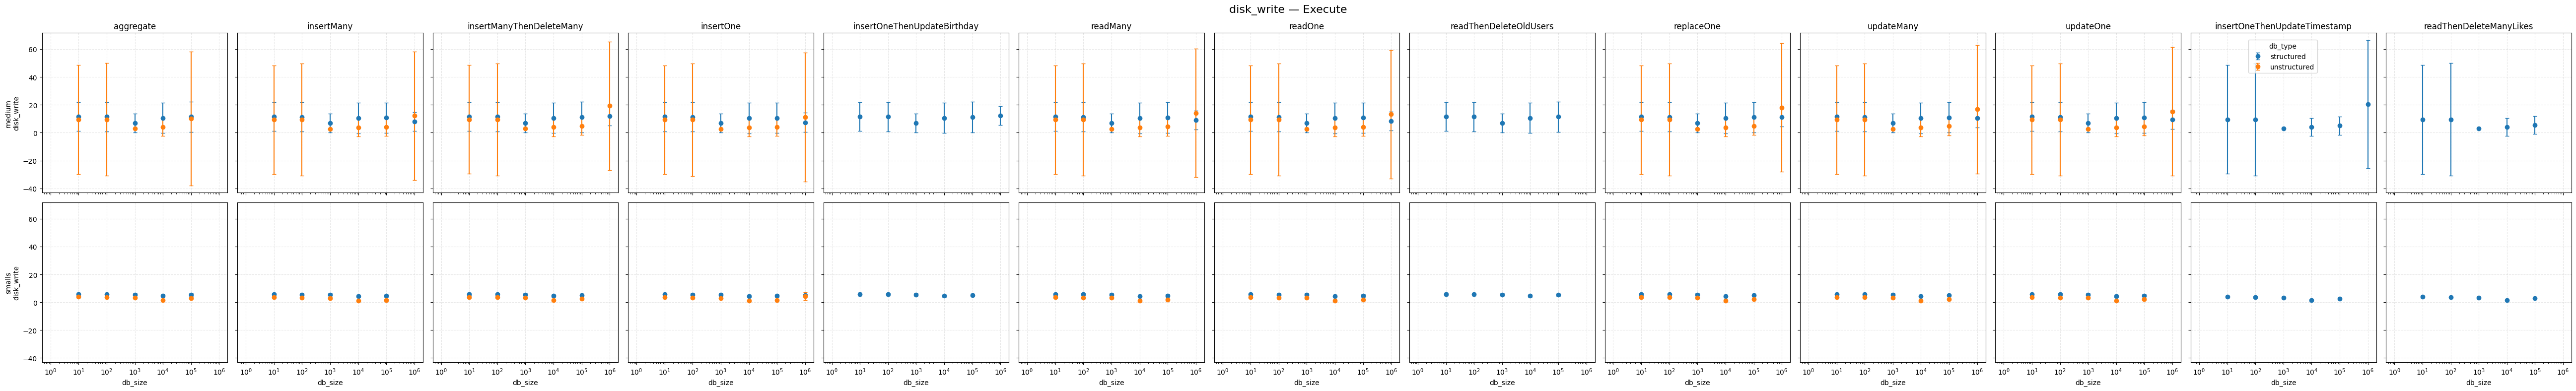

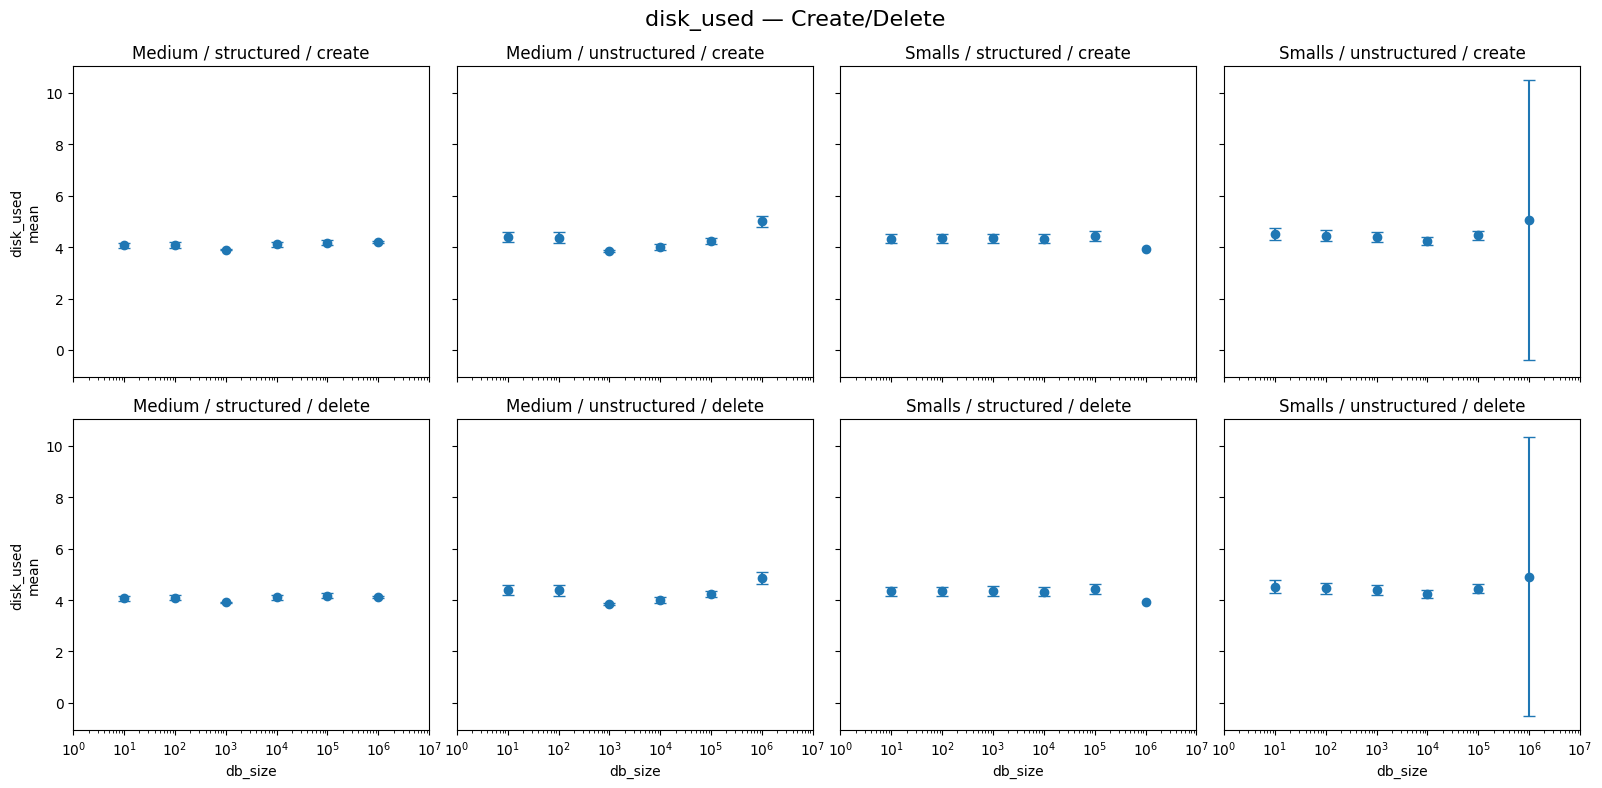

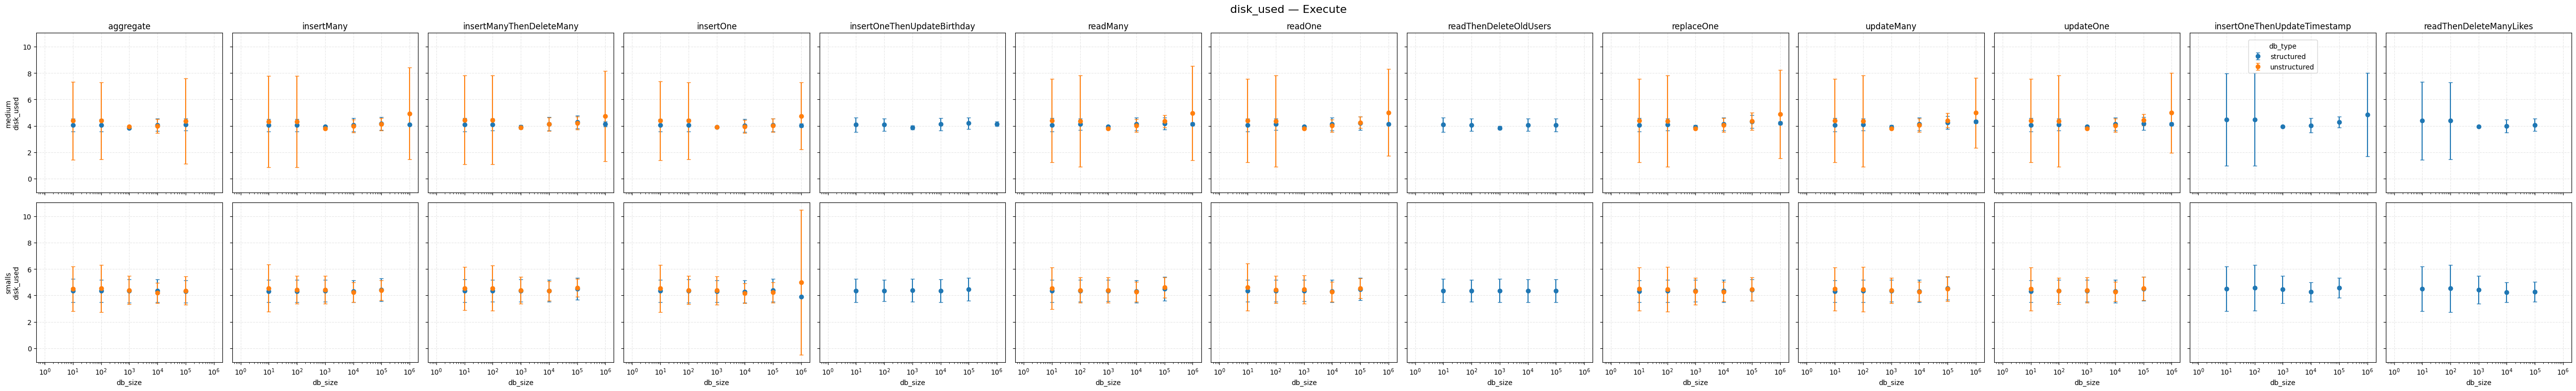

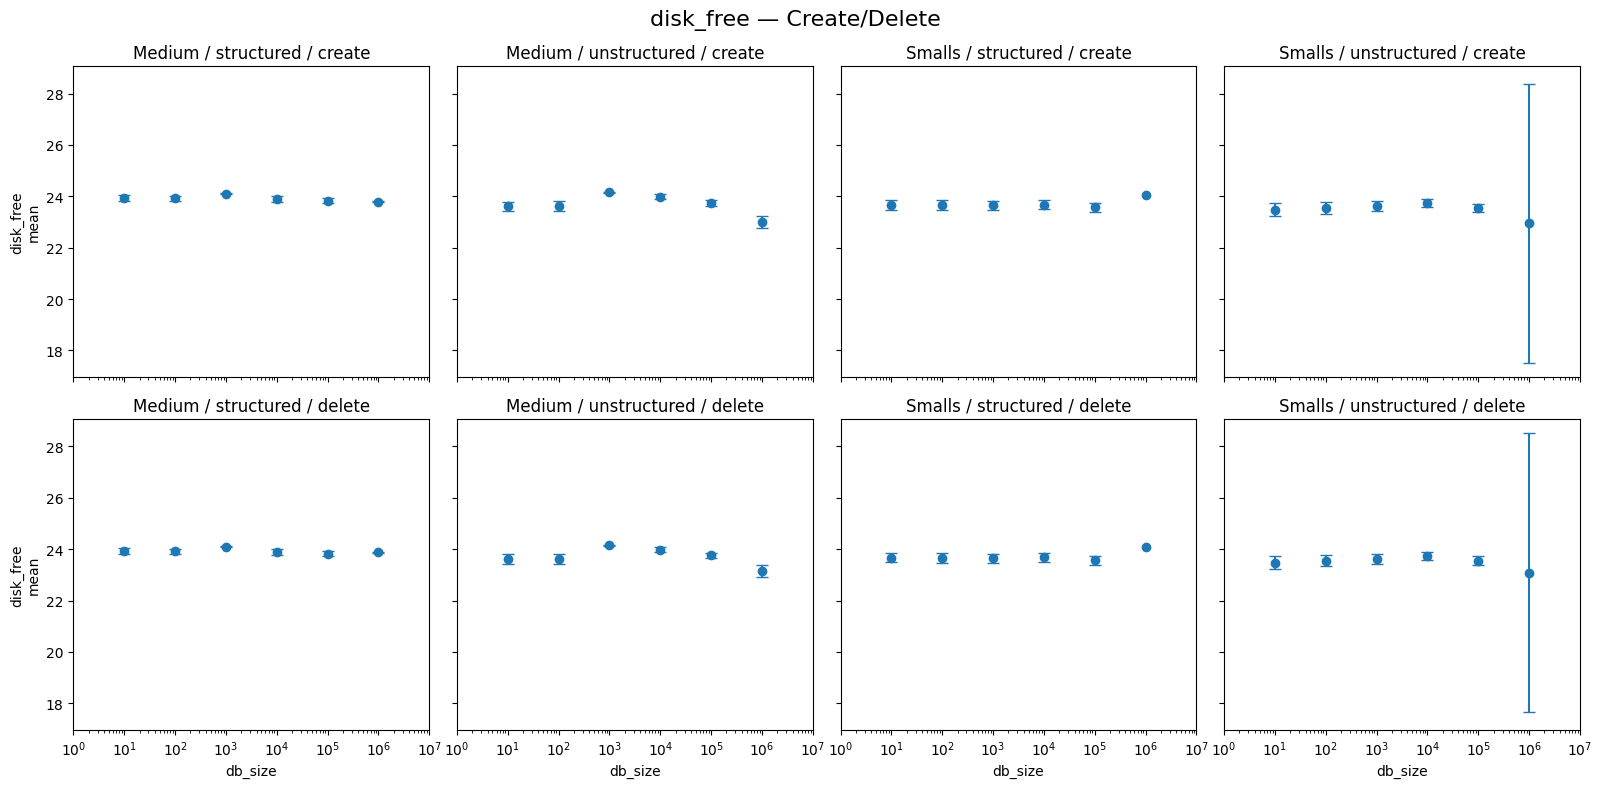

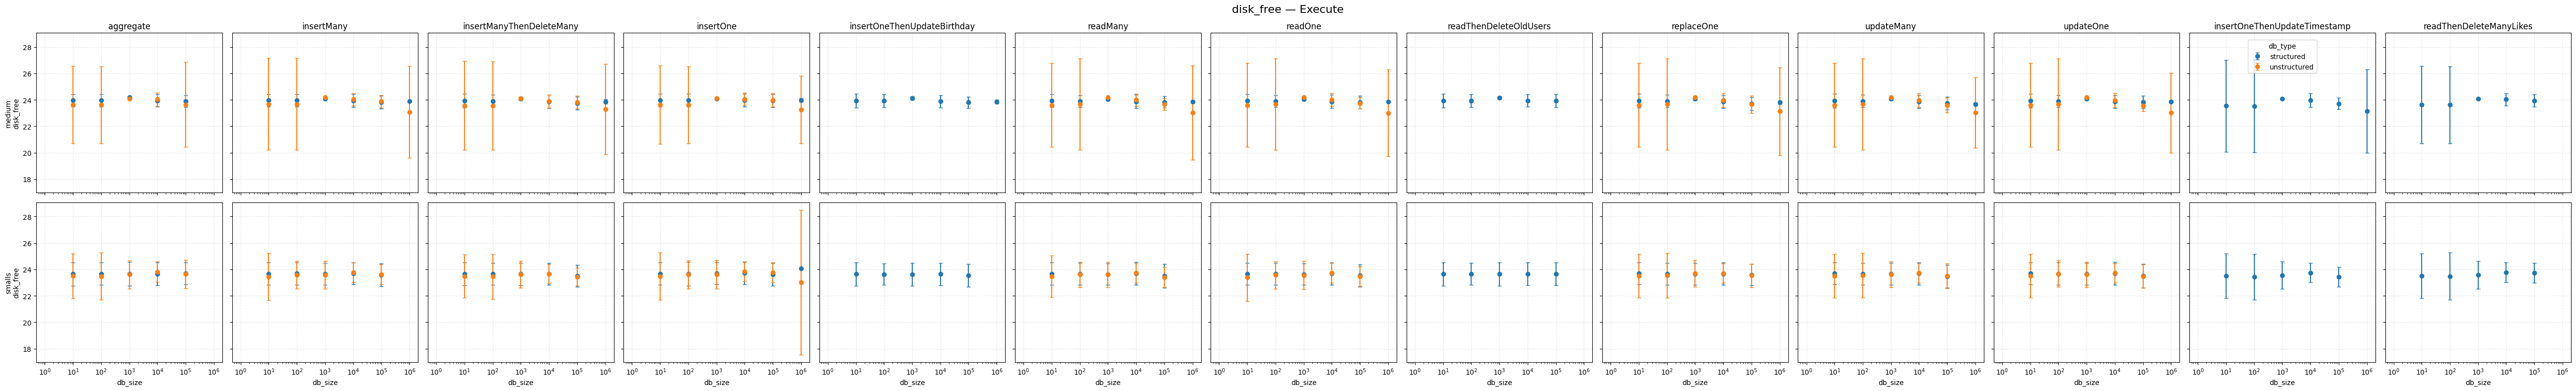

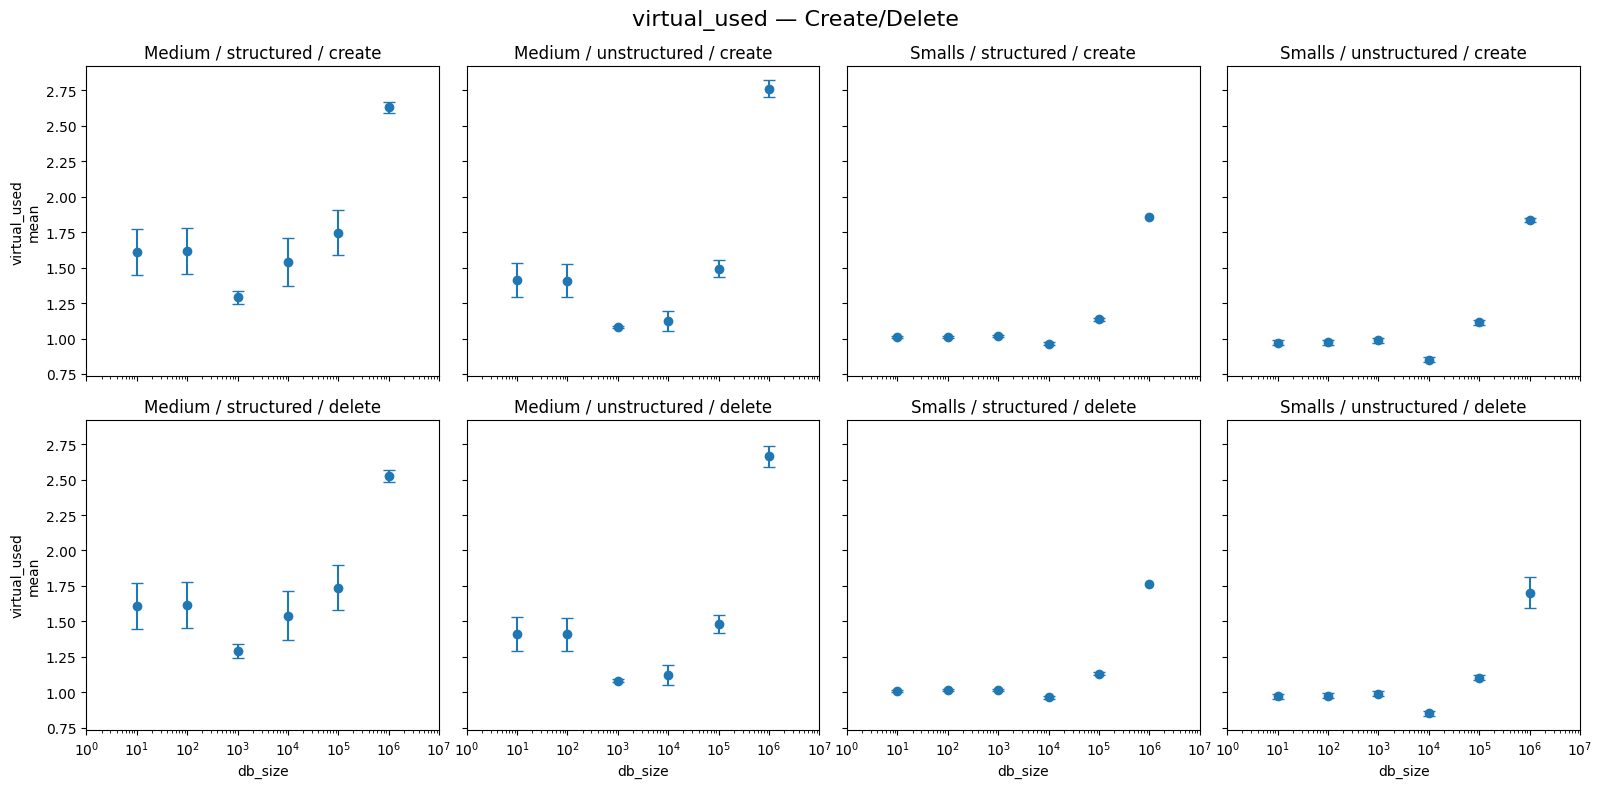

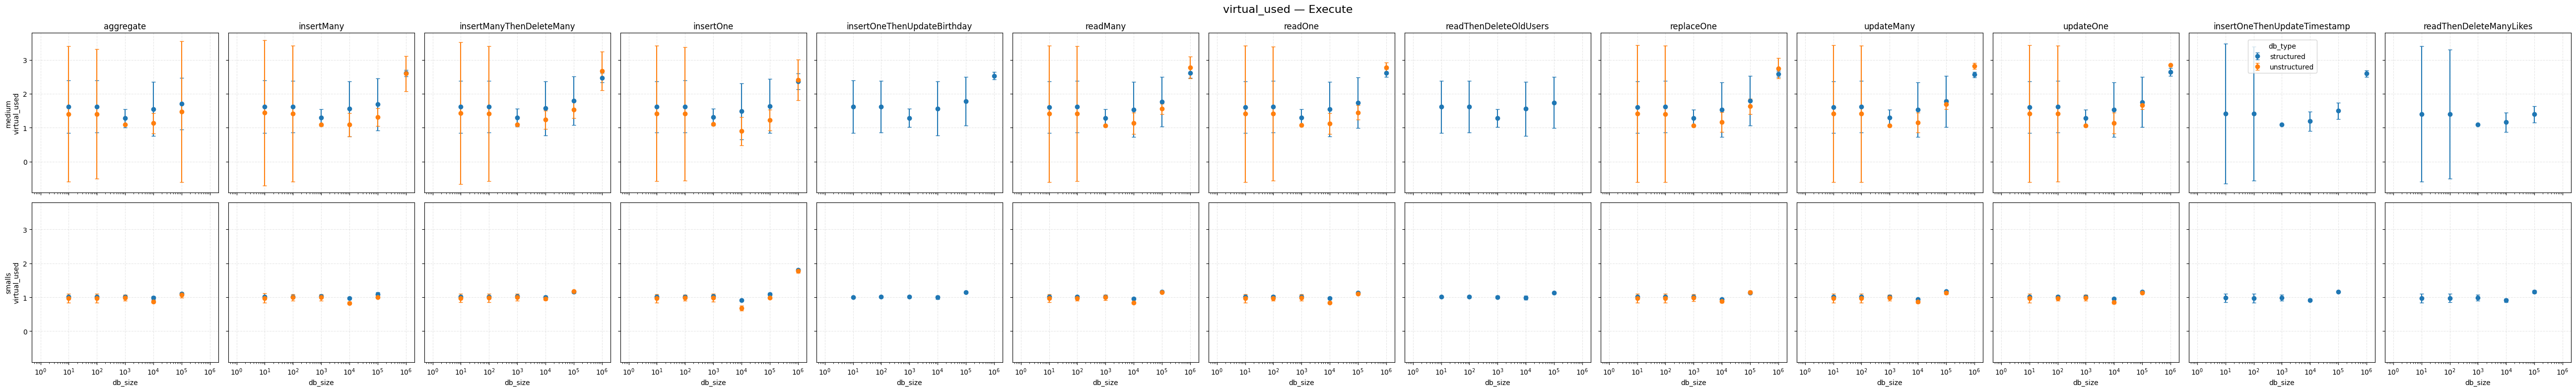

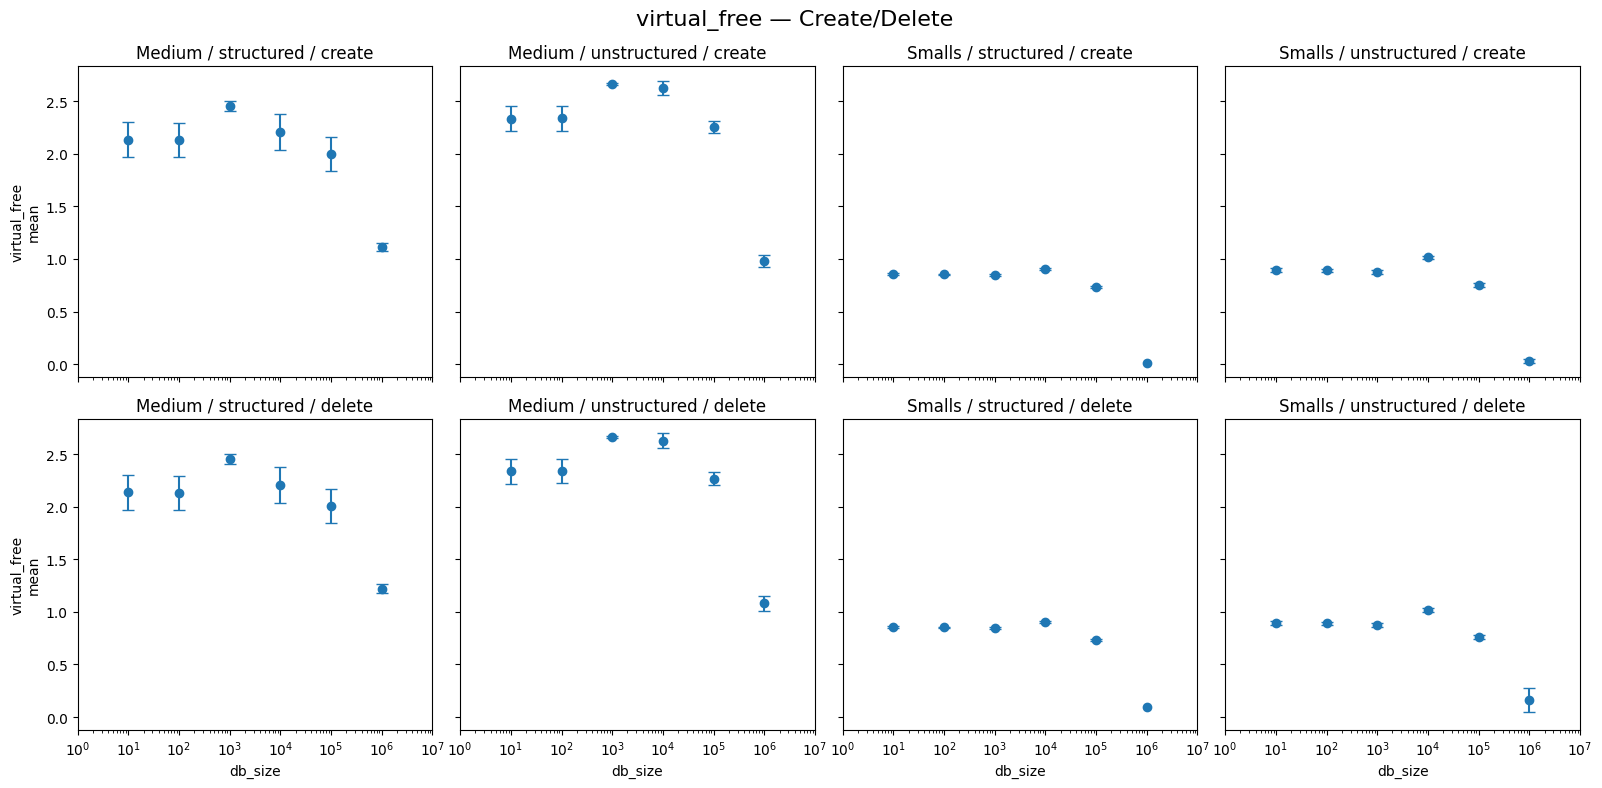

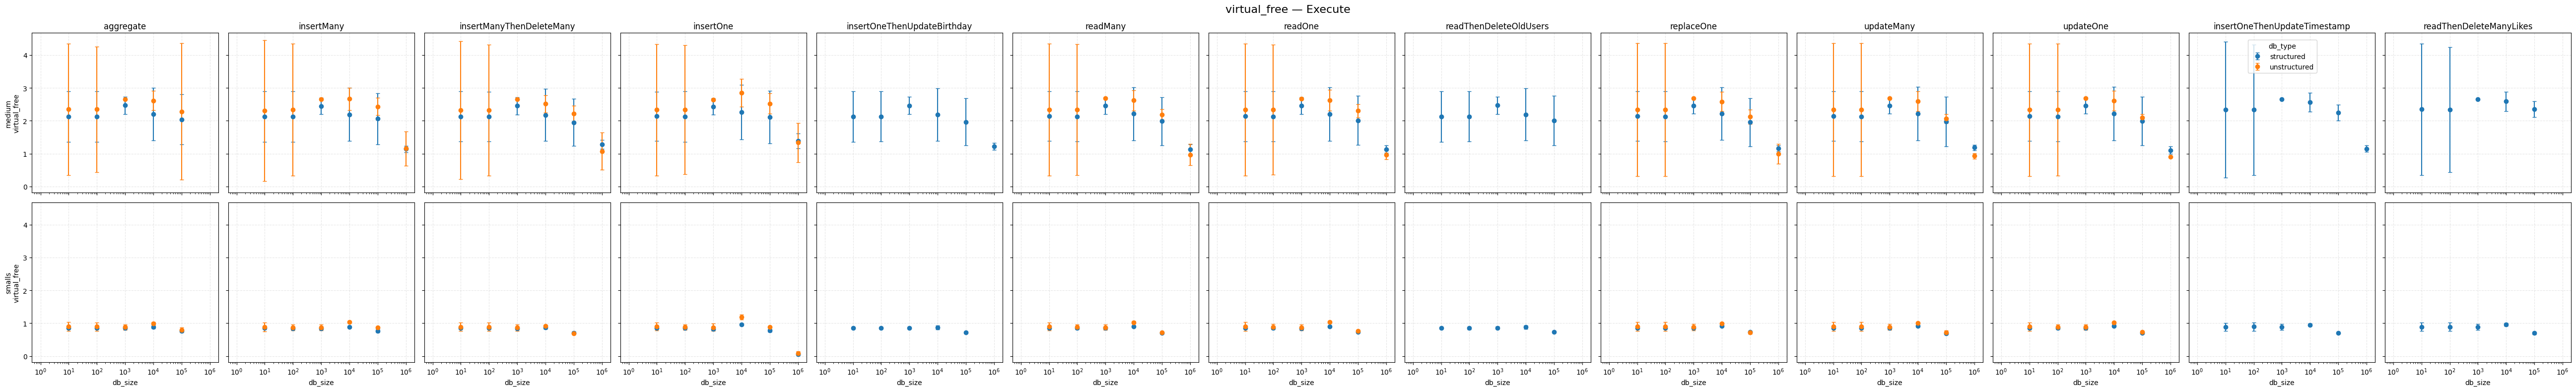

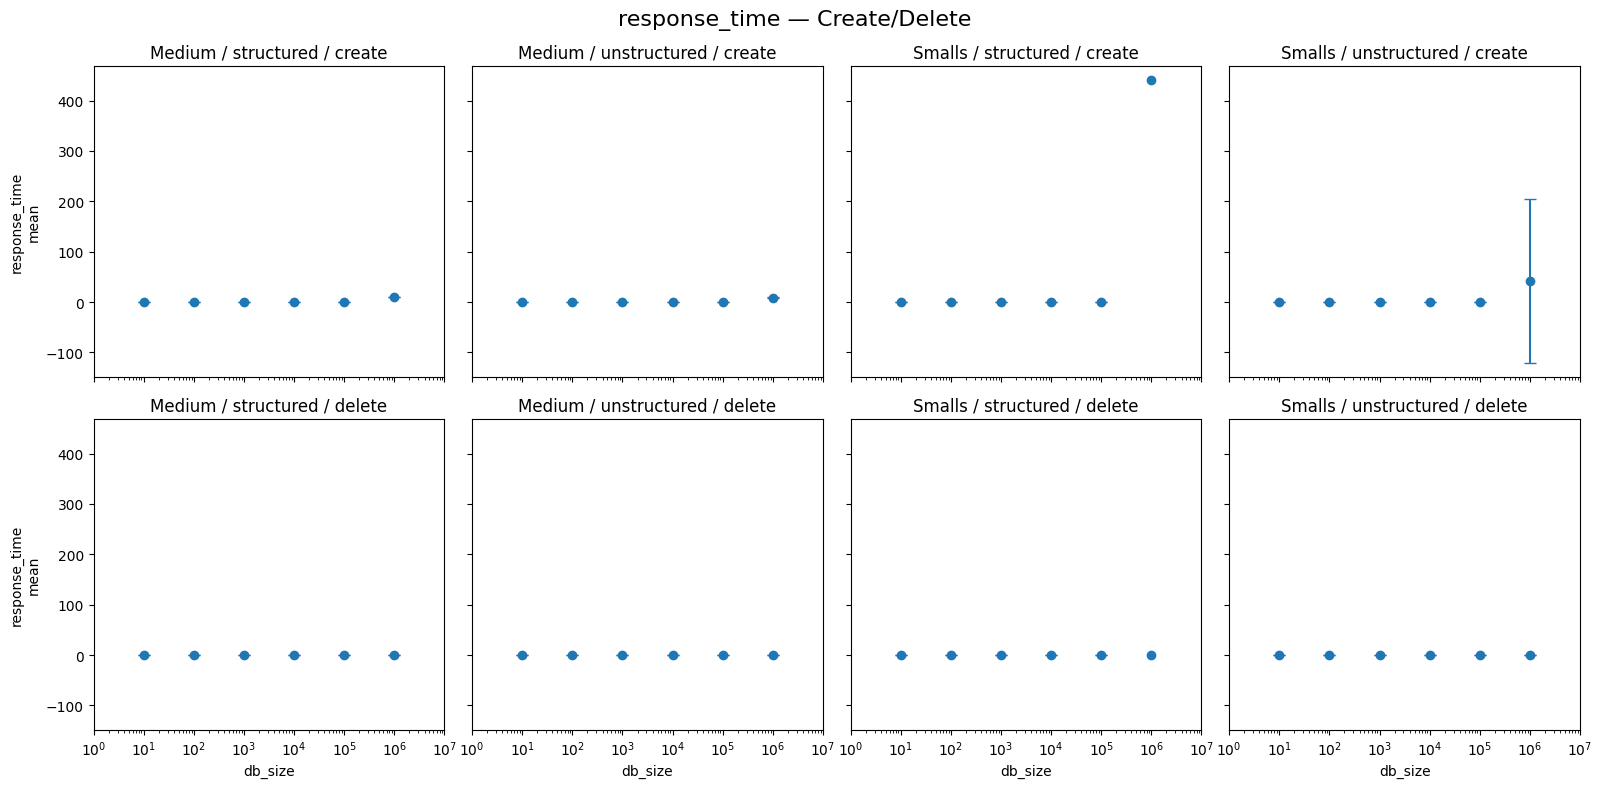

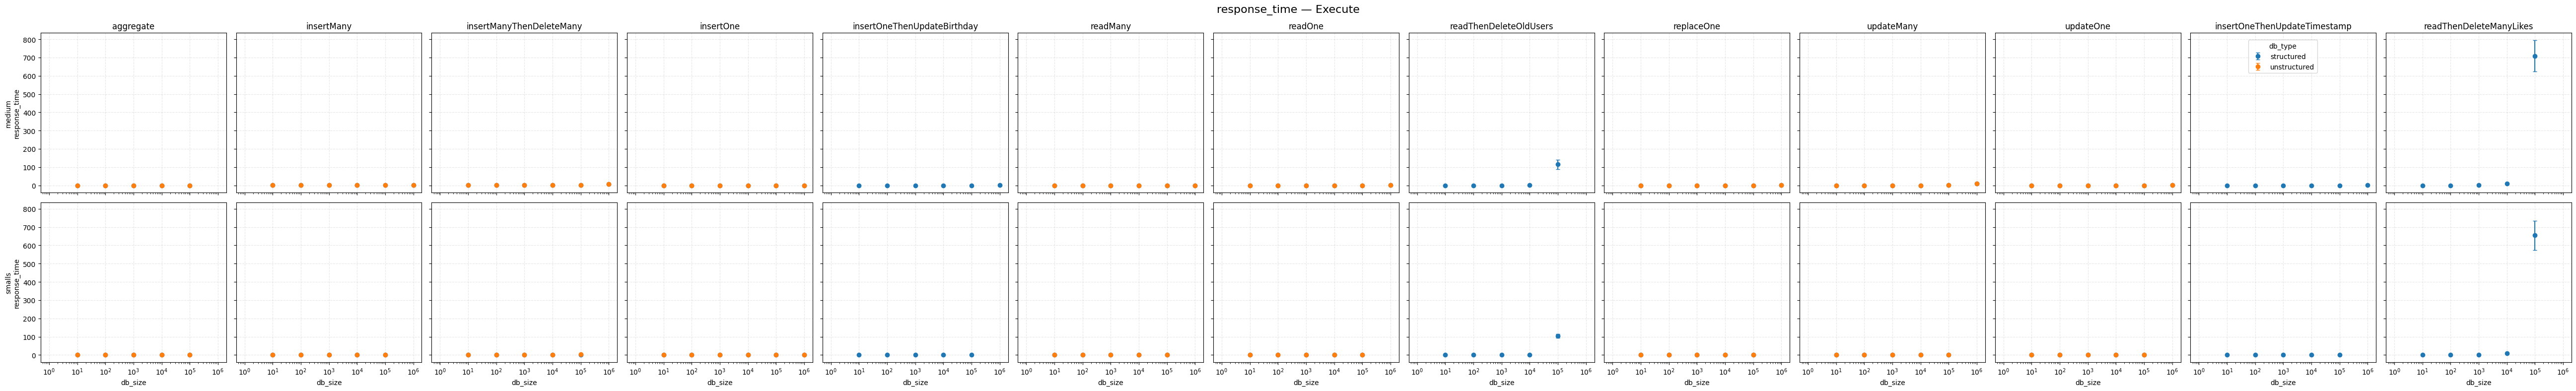

In [81]:
def plotOverview():
    # the collected metrics to look through
    metrics = [
        "cpu_util",
        'disk_read',
        'disk_write',
        'disk_used',
        'disk_free',
        'virtual_used',
        'virtual_free',
        'response_time'
    ]

    # operations to view
    operations = ['create', 'delete']
    machines   = ['medium', 'smalls']
    db_types   = ['structured', 'unstructured']

    # plot create/delete
    def plot_cd_metric(cd_df, metric):
        fig, axes = plt.subplots(
            nrows=len(operations),
            ncols=len(machines)*len(db_types),
            figsize=(16, 8),
            sharex=True,
            sharey=True
        )

        for i, op in enumerate(operations):
            j = 0

            for machine in machines:
                for dbt in db_types:
                    ax = axes[i, j]
                    sub = cd_df[
                        (cd_df['operation'] == op) &
                        (cd_df['machine']   == machine) &
                        (cd_df['db_type']   == dbt)
                    ]

                    if sub.empty:
                        ax.set_visible(False)
                    else:
                        y = sub['mean']
                        yerr = [y - sub['ci_lower'], sub['ci_upper'] - y]
                        ax.errorbar(
                            sub['db_size'],
                            y,
                            yerr=yerr,
                            fmt='o',
                            capsize=4
                        )

                        ax.set_title(f"{machine.capitalize()} / {dbt} / {op}", pad=6)
                        ax.set_xscale('log')
                        ax.set_xlim(1, 1e7)

                    if i == len(operations) - 1:
                        ax.set_xlabel('db_size')
                    if j == 0:
                        ax.set_ylabel(f"{metric}\nmean")
                    j += 1

        fig.suptitle(f"{metric} — Create/Delete", fontsize=16)
        plt.tight_layout()
        plt.show()

    # plot execute
    def plot_ex_metric(ex_df, metric):
        functions = ex_df['function'].unique().tolist()

        fig, axes = plt.subplots(
            nrows=len(machines),
            ncols=len(functions),
            figsize=(4 * len(functions), 4 * len(machines)),
            sharex=True,
            sharey=True
        )

        for i, machine in enumerate(machines):
            for j, func in enumerate(functions):
                ax = axes[i, j]
                sub = ex_df[
                    (ex_df['machine']  == machine) &
                    (ex_df['function'] == func)
                ]

                if sub.empty:
                    ax.set_visible(False)
                else:
                    for dbt, grp in sub.groupby('db_type'):
                        y = grp['mean']
                        yerr = [y - grp['ci_lower'], grp['ci_upper'] - y]
                        ax.errorbar(
                            grp['db_size'],
                            y,
                            yerr=yerr,
                            fmt='o',
                            capsize=3,
                            label=dbt
                        )

                    if i == 0:
                        ax.set_title(func, pad=6)
                    if j == 0:
                        ax.set_ylabel(f"{machine}\n{metric}")
                    if i == len(machines) - 1:
                        ax.set_xlabel('db_size')
                    ax.set_xscale('log')
                    ax.grid(True, linestyle='--', alpha=0.3)

        # one legend for db_type
        handles, labels = axes[0,0].get_legend_handles_labels()
        fig.legend(handles, labels, title='db_type', loc='upper right', bbox_to_anchor=(0.9, 0.9))
        fig.suptitle(f"{metric} — Execute", fontsize=16)
        plt.tight_layout()
        plt.show()

    # loop over metrics, compute CI, plot
    for metric in metrics:
        # for “execute” (default=True), and for “create/delete” (pass execute=False)
        ex_df = block_confidence(t_df.copy(), metric, alpha=0.1)            # executes
        cd_df = block_confidence(t_df.copy(), metric, alpha=0.1, execute_only=False)  # create/delete

        plot_cd_metric(cd_df, metric)
        plot_ex_metric(ex_df, metric)

plotOverview()

Cpu utilization

Disk
- by GiB
- by Percent

RAM - Virtual Memory

Response Time